# GALAH DR3 Tutorial 3: Plotting Reduced Spectra

What you need to know:
The GALAH spectra come in 4 FITS files, for each of the 4 CCDs

Each FITS has several extensions:
FITS[0]: reduced flux
FITS[1]: relative error spectrum
FITS[2]:
FITS[3]:
FITS[4]:

Note: For some nights, CCD4 FITS files are missing...

#### Author(s):
Sven Buder (SB, sven.buder@anu.edu.au)

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import os
import wget
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import glob

# Key decisions:

In [2]:
# Adjust directory you want to work in
working_directory = '/Users/svenbuder/GALAH_DR3/spectra/SPECTRA/'
os.chdir(working_directory)

# Choose if you want to plot the lines used for DR3.
# If you want to plot that, you have to give a path to the mode_DR3 file
plot_elements = True
mode_dr3_path = '../../analysis/abundances/mode_DR3_collect'

# Choose if you want to plot the normalised or reduced spectra
normalised = True

# Choose if you want to have some additional help because this is a tutorial
tutorial = False

# Choose if you want to save the plot as PNG file
savefig = True

In [3]:
# Put the sobject_ids here
sobject_ids = [
    161213002101285,
    161217002601184
]

In [4]:
def load_dr3_lines(mode_dr3_path = '../../analysis/abundances/mode_DR3'):
    """
    
    """
    important_lines = dict()

    important_lines[1] = []
    important_lines[2] = []
    important_lines[3] = []
    important_lines[4] = []

    important_molecules = dict()
    important_molecules[1] = [[4710,4740,'Mol. C2']]
    important_molecules[2] = [[]]
    important_molecules[3] = [[]]
    important_molecules[4] = [[7594,7695,'Mol. O2 (tell.)']]

    try:
        print('Trying to read in list of elements run as part of DR3')
        line, wave = np.loadtxt(mode_dr3_path,usecols=(0,1),unpack=True,dtype=str, comments=';')

        for each_index in range(len(line)):
            if line[each_index] != 'Sp':
                if (float(wave[each_index]) > 4710) & (float(wave[each_index]) < 4905):
                    if len(line[each_index]) < 5:
                        important_lines[1].append([float(wave[each_index]), line[each_index], line[each_index]])
                    else:
                        important_lines[1].append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
                if (float(wave[each_index]) > 5645) & (float(wave[each_index]) < 5877.5):
                    if len(line[each_index]) < 5:
                        important_lines[2].append([float(wave[each_index]), line[each_index], line[each_index]])
                    else:
                        important_lines[2].append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
                if (float(wave[each_index]) > 6472.5) & (float(wave[each_index]) < 6740):
                    if len(line[each_index]) < 5:
                        important_lines[3].append([float(wave[each_index]), line[each_index], line[each_index]])
                    else:
                        important_lines[3].append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
                if (float(wave[each_index]) > 7580) & (float(wave[each_index]) < 7890):
                    if len(line[each_index]) < 5:
                        important_lines[4].append([float(wave[each_index]), line[each_index], line[each_index]])
                    else:
                        important_lines[4].append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
        important_lines[1].sort()
        important_lines[2].sort()
        important_lines[3].sort()
        important_lines[4].sort()
        print('Success')
    except:
        print('Could not read in list of elements run as part of DR3')
        
    return(important_lines,important_molecules)

In [5]:
def downdload_spectra(sobject_id,ccd):
    """
    Try to download the specfici spectrum from Datacentral
    """
    try:
        if tutorial:
            print('Trying to download '+str(sobject_id)+str(ccd)+'.fits from')
            print('https://cloud.datacentral.org.au/apps/files/?dir=/GALAH/DR3/data/galah/dr3/spectra/'+str(sobject_id)+str(ccd)+'.fits')
        wget.download(
            'https://cloud.datacentral.org.au/apps/files/?dir=/GALAH/DR3/data/galah/dr3/spectra/'+str(sobject_id)+str(ccd)+'.fits',
            working_directory+str(sobject_id)+str(ccd)+'.fits'
        )
        return [working_directory+str(sobject_id)+str(ccd)+'.fits']
    except:
        try:
            if str(sobject_id)[11]=='1':
                os.system('rsync -azu -P buder@avatar:/avatar/buder/trunk/GALAH/SPECTRA/dr5.3/'+str(sobject_id)[:6]+'/standard/com/'+str(sobject_id)+'*.fits .')
            else:
                os.system('rsync -azu -P buder@avatar:/avatar/buder/trunk/GALAH/SPECTRA/dr5.3/'+str(sobject_id)[:6]+'/standard/com2/'+str(sobject_id)+'*.fits .')
            return [working_directory+str(sobject_id)+str(ccd)+'.fits']
        except:
            print('FITS '+str(sobject_id)+str(ccd)+' not available on AVATAR')
        print('FITS '+str(sobject_id)+str(ccd)+' not available')
        return []

In [6]:
def read_spectra(sobject_id, tutorial=True):
    """
    Read in all available CCDs and give back a dictionary
    Downlaod them if not already in working directory
    """
    
    # Check if FITS files already available in working directory
    fits_files = [[], [], [], []]
    for each_ccd in [1,2,3,4]:
        fits_files[each_ccd-1] = glob.glob(working_directory+str(sobject_id)+str(each_ccd)+'.fits')
    # If not already available, try to download
    for each_ccd in [1,2,3,4]:
        if fits_files[each_ccd-1] == []:
            fits_files[each_ccd-1] = downdload_spectra(sobject_id,each_ccd)
    
    spectrum = dict()
    for each_ccd in [1,2,3,4]:
        if fits_files[each_ccd-1]!=[]:
            fits = pyfits.open(fits_files[each_ccd-1][0])
            
            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]
            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength)

            # Extract wavelength grid for the normalised spectrum
            start_wavelength = fits[4].header["CRVAL1"]
            dispersion       = fits[4].header["CDELT1"]
            nr_pixels        = fits[4].header["NAXIS1"]
            reference_pixel  = fits[4].header["CRPIX1"]
            if reference_pixel == 0:
                reference_pixel=1
            spectrum['wave_norm_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength)

            # Extract flux and flux error of reduced spectrum
            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data)
            spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            # Extract flux and flux error of reduced spectrum
            spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
            if each_ccd != 4:
                spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
            else:
                # for normalised error of CCD4, only used appropriate parts of error spectrum
                spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])

            fits.close()
        else:
            spectrum['wave_red_'+str(each_ccd)] = []
            spectrum['wave_norm_'+str(each_ccd)] = []
            spectrum['sob_red_'+str(each_ccd)] = []
            spectrum['sob_norm_'+str(each_ccd)] = []
            spectrum['uob_red_'+str(each_ccd)] = []
            spectrum['uob_norm_'+str(each_ccd)] = []
    
    spectrum['wave_red'] = np.concatenate(([spectrum['wave_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['wave_norm'] = np.concatenate(([spectrum['wave_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_red'] = np.concatenate(([spectrum['sob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_norm'] = np.concatenate(([spectrum['sob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_red'] = np.concatenate(([spectrum['uob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_norm'] = np.concatenate(([spectrum['uob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    
    if tutorial:
        print('TUTORIAL:')
        print('The spectra of the 4 CCDs are now read in and saved in a dictionary')
        print('For convenience, the wavelength (wave_*), observed signal (sob_*), and uncertainties of the observed signal (uob_*) for both reduced (*red*) and normalised (*norm*) are saved both for each CCD (*_1/*_2/*_3/*_4) as well as concatenated')
        print('The dictionary therefore has the keywords')
        print(spectrum.keys())
    return spectrum

In [7]:
def plot_spectra(sobject_id, normalised=True, plot_elements=True, savefig=False, tutorial=True):
    """
    Plot the spectra in a 4x1 panel figure
    """
    f, ccds = plt.subplots(4,1,figsize=(11.69, 8.27))
    kwargs_sob = dict(c = 'k', lw=0.5, label='Flux', rasterized=True)
    kwargs_error_spectrum = dict(color = 'grey', label='Flux error', rasterized=True)

    for each_ccd in [1,2,3,4]:
        ax=ccds[each_ccd-1]
        
        if normalised:
            red_norm = 'norm'
        else:
            red_norm = 'red'
            
        # Plot the uncertainty as grey background
        ax.fill_between(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] - spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] + spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_error_spectrum
            )
        
        # Overplot observed spectrum a bit thicker
        ax.plot(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_sob
            )
        
        if normalised:
            ax.set_ylabel('Flux [norm.]')
            ax.set_ylim(-0.1,1.3)
        else:
            ax.set_ylabel('Counts')
            ax.set_ylim(0,1.1*np.percentile(spectrum['sob_red_'+str(each_ccd)],q=95))
        if each_ccd == 1:
            ax.set_title(str(sobject_id))
            ax.set_xlim(4710,4905)
        if each_ccd == 2:
            ax.set_xlim(5645,5877.5)
        if each_ccd == 3:
            ax.set_xlim(6472.5,6740)
        if each_ccd == 4:
            ax.set_xlim(7580,7890)
            ax.set_xlabel('Wavelength [Å]')
        if each_ccd == 4:
            ax.legend(loc='lower left')

        if plot_elements & normalised:
            if each_ccd==1:
                ax.axvline(4861.3230,lw=0.2,ls='dashed',c='r')
                ax.text(4861.3230,1.15,r'H$_\beta$',fontsize=10,ha='center',color='k')
            if each_ccd==3:
                ax.axvline(6562.7970,lw=0.2,ls='dashed',c='r')
                ax.text(6562.7970,1.15,r'H$_\alpha$',fontsize=10,ha='center',color='k')
            for each_index, each_element in enumerate(important_lines[each_ccd]):
                offset = 0.1*(each_index%3)
                ax.axvline(each_element[0],lw=0.2,ls='dashed',c='r')
                if each_element[1] in ['Li','C','O']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='pink')
                elif each_element[1] in ['Mg','Si','Ca','Ti','Ti2']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='b')
                elif each_element[1] in ['Na','Al','K']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='orange')
                elif each_element[1] in ['Sc','V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='brown')
                elif each_element[1] in ['Rb', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Ce','Mo','Ru', 'Nd', 'Sm','Eu']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='purple')
            if each_ccd in [1,4]:
                for each_molecule in important_molecules[each_ccd]:
                    ax.axvspan(each_molecule[0],each_molecule[1],color='y',alpha=0.05)
                    ax.text(0.5*(each_molecule[0]+each_molecule[1]),1.15,each_molecule[2],fontsize=10,ha='center',color='k')                
    plt.tight_layout()
    if savefig:
        plt.savefig(working_directory+str(sobject_id)+'_'+red_norm+'.png',bbox_inches='tight',dpi=200)
    plt.show()
    plt.close()
    
    return f

Trying to read in list of elements run as part of DR3
Success


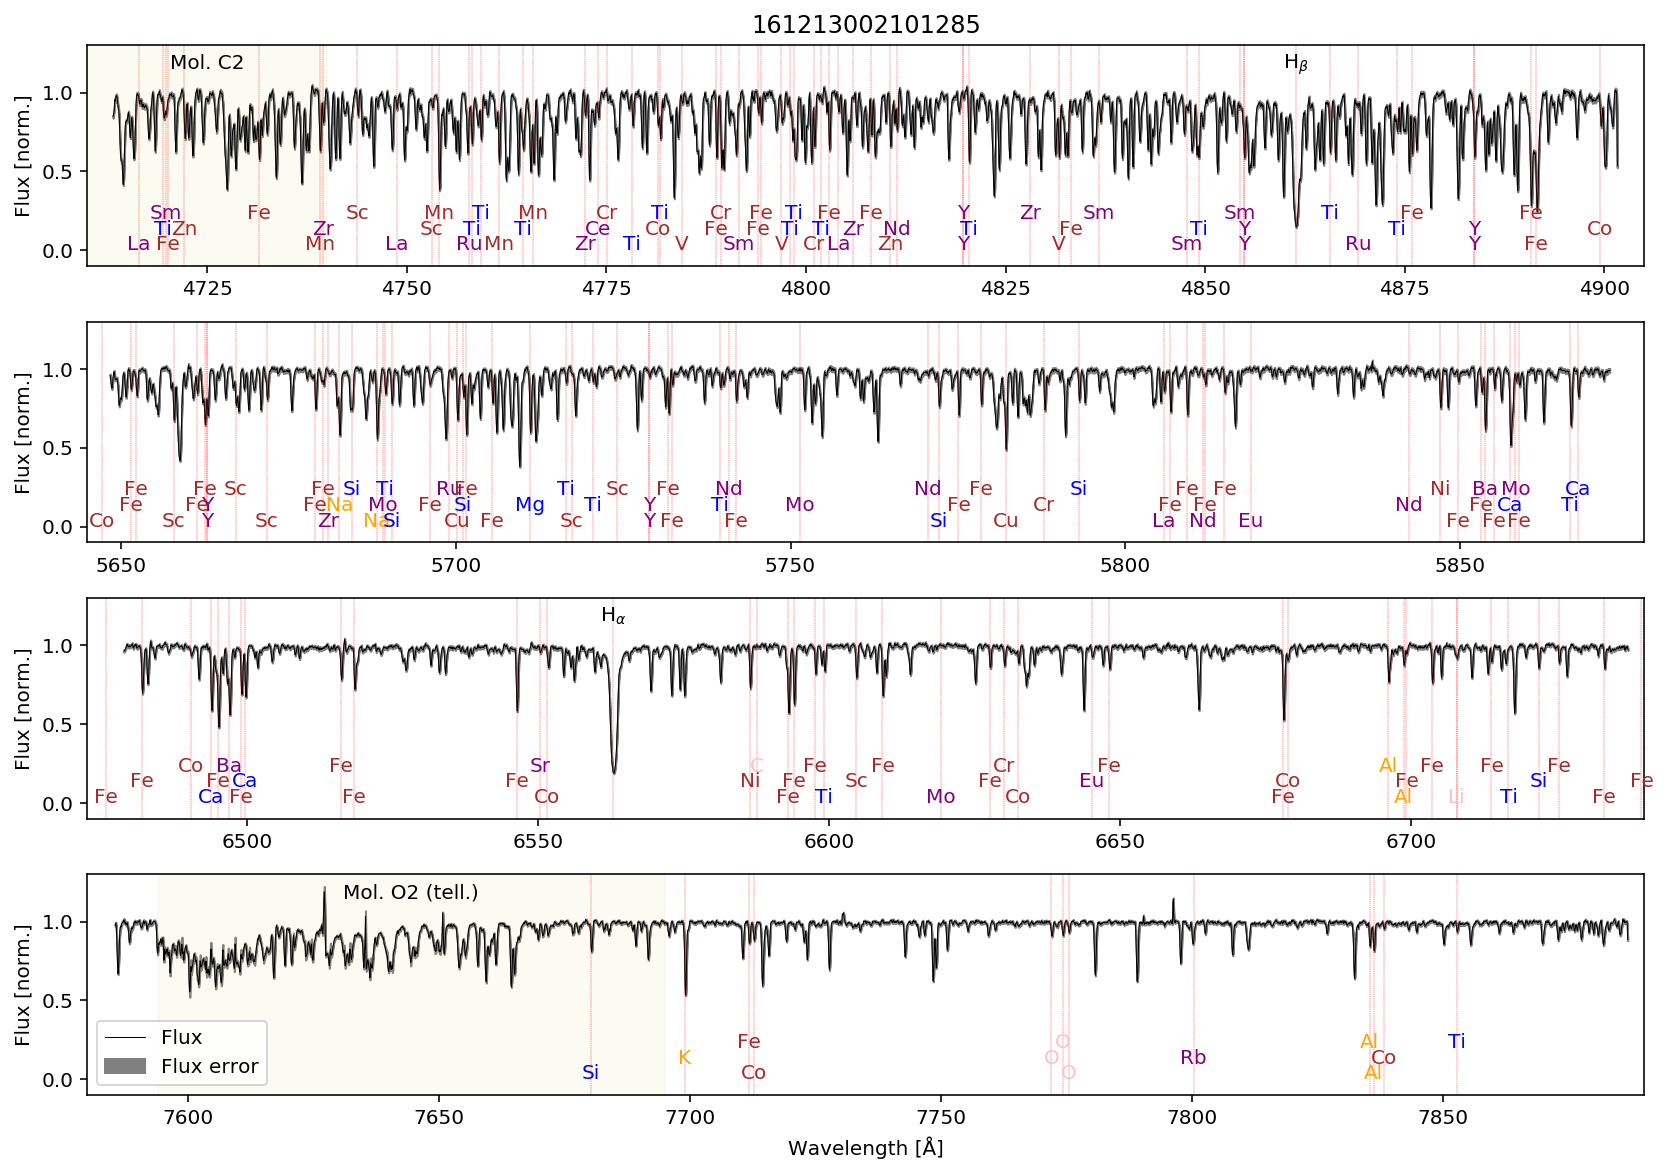

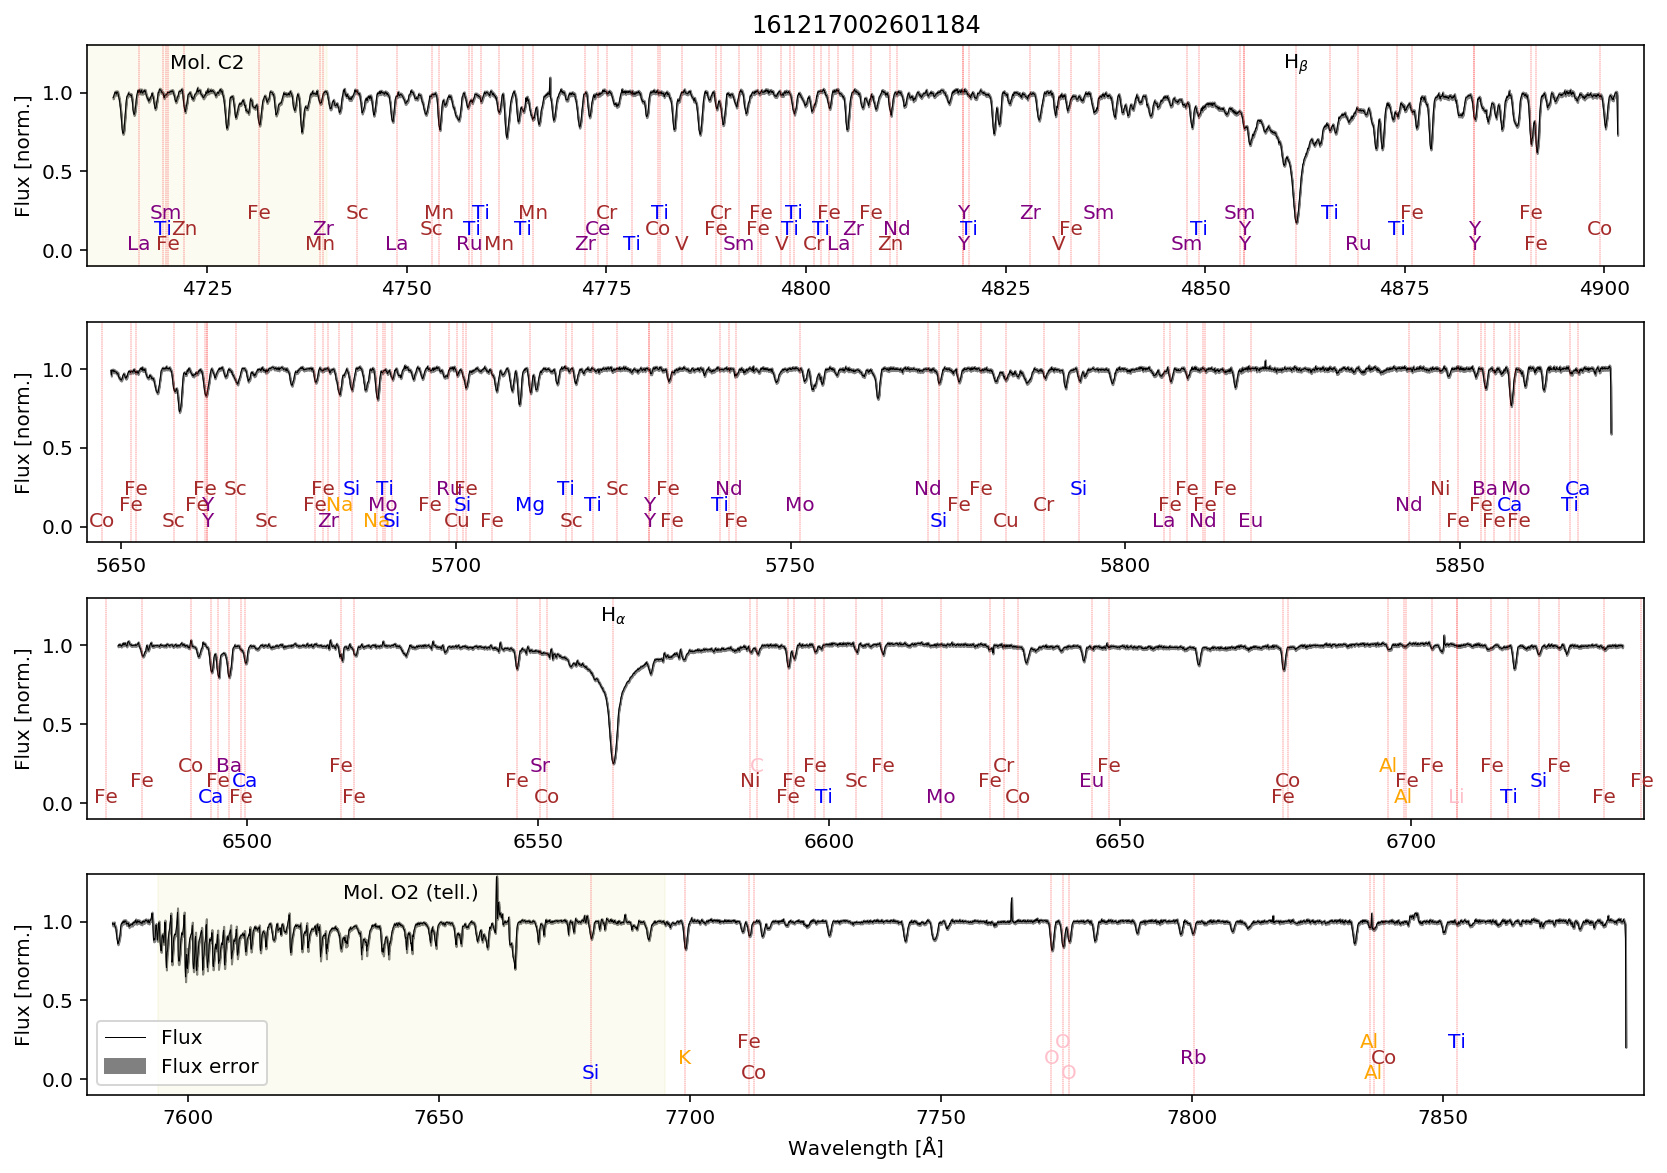

In [8]:
if plot_elements:
    important_lines, important_molecules = load_dr3_lines()

for sobject_id in sobject_ids:
    spectrum = read_spectra(sobject_id, tutorial=tutorial)
    f = plot_spectra(sobject_id, normalised=normalised, plot_elements=plot_elements, savefig=savefig, tutorial=tutorial)